#### Library import

In [1]:
import uuid
from functions import A_preprocessing as preprocessing
# from functions import B_create_feature_store as feature_store
from functions import C_task1_model_train as create_model
from functions import D_task2 as task2
# from functions import deploy_model as deploy

## 1. Pre-processing

In [2]:
df = preprocessing.read_dataset("data/raw_dataset/datasetWithMoreData.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_TIME                       float64
 3   DEP_DELAY_NEW                  float64
 4   DEP_DEL15                      int64  
 5   DEP_TIME_BLK                   object 
 6   ARR_TIME                       float64
 7   ARR_DELAY_NEW                  float64
 8   ARR_TIME_BLK                   object 
 9   DISTANCE_GROUP                 int64  
 10  SEGMENT_NUMBER                 int64  
 11  CONCURRENT_FLIGHTS             int64  
 12  NUMBER_OF_SEATS                int64  
 13  CARRIER_NAME                   object 
 14  AIRPORT_FLIGHTS_MONTH          int64  
 15  AIRLINE_FLIGHTS_MONTH          int64  
 16  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 17  AVG_MONTHLY_PASS_AIRPORT       int64  
 18  AV

In [ ]:
df.head()

In [ ]:
preprocessing.remove_null_values(df)

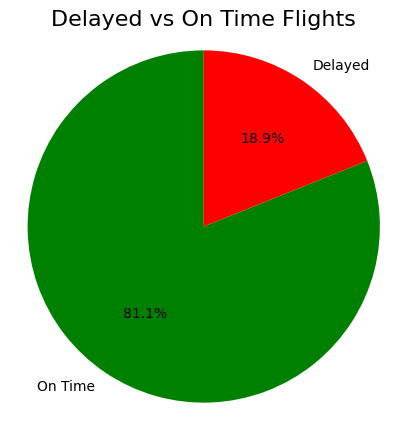

In [3]:
preprocessing.delayed_flights(df)

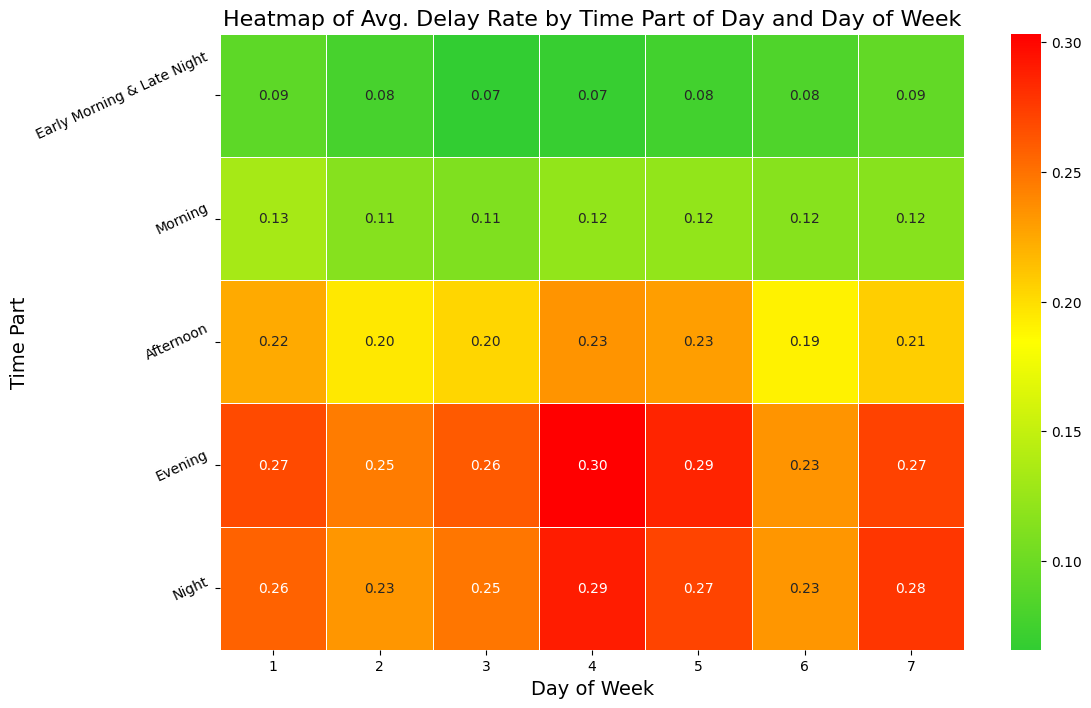

In [4]:
preprocessing.create_part_of_day_column(df)
preprocessing.show_heatmap_part_of_day(df)

In [ ]:
#df.head()

df['ID'] = [uuid.uuid4() for _ in range(len(df))]
df['ID'] = df['ID'].astype(str)

weather_columns = ['ID', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
weather_df = df[weather_columns]

weather_feature_descriptions = [
    {"name": "id", "description": "flight id"},
    {"name": "prcp", "description": "inches of precipitation for day"},
    {"name": "snow", "description": "inches of snowfall for day"},
    {"name": "snwd", "description": "inches of snow on ground for day"},
    {"name": "tmax", "description": "max temperature for day"},
    {"name": "awnd", "description": "max wind speed for day"},
]

flight_airport_columns = ['ID', 'MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'PART_OF_DAY', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE', 'LONGITUDE', 'PREVIOUS_AIRPORT']
flight_airport_df = df[flight_airport_columns]

flight_airport_feature_descriptions = [
    {"name": "id", "description": "flight id"},
    {"name": "month", "description": "month"},
    {"name": "day_of_week", "description": "day of week"},
    {"name": "distance_group", "description": "distance group to be flown by departing aircraft"},
    {"name": "part_of_day", "description": "part of the day that the flight is scheduled for departure"},
    {"name": "segment_number", "description": "the segment that this tail number is on for the day"},
    {"name": "concurrent_flights", "description": "concurrent flights leaving from the airport in the same departure block"},
    {"name": "number_of_seats", "description": "number of seats on the aircraft"},
    {"name": "carrier_name", "description": "carrier"},
    {"name": "airport_flights_month", "description": "avg airport flights per month"},
    {"name": "airline_flights_month", "description": "avg airline flights per month"},
    {"name": "airline_airport_flights_month", "description": "avg flights per month for airline and airport"},
    {"name": "avg_monthly_pass_airport", "description": "avg passengers for the departing airport for the month"},
    {"name": "avg_monthly_pass_airline", "description": "avg passengers for airline for month"},
    {"name": "flt_attendants_per_pass", "description": "flight attendants per passenger for airline"},
    {"name": "ground_serv_per_pass", "description": "ground service employees (service desk) per passenger for airline"},
    {"name": "plane_age", "description": "age of departing aircraft"},
    {"name": "departing_airport", "description": "departing airport"},
    {"name": "latitude", "description": "latitude of departing airport"},
    {"name": "longitude", "description": "longitude of departing airport"},
    {"name": "previous_airport", "description": "previous airport that aircraft departed from"},
]

target_column = ['ID', 'DEP_DEL15']
target_df = df[target_column]

target_feature_descriptions = [
    {"name": "id", "description": "flight id"},
    {"name": "dep_del15", "description": "binary of a departure delay over 15 minutes (1 is yes)"},
]

## 2. Hopsworks connection

In [ ]:
project, fs = feature_store.connect_to_hopsworks()

If feature groups have not already been created, uncomment this part of the code

In [ ]:
# feature_store.create_feature_group("flight_airport", 1, "Flight and Airport Information", ["id"], True, fs, flight_airport_df, flight_airport_feature_descriptions)
# feature_store.create_feature_group("weather", 1, "Weather Information", ["id"], True, fs, weather_df, weather_feature_descriptions)
# feature_store.create_feature_group("target", 1, "Target Information", ["id"], True, fs, target_df, target_feature_descriptions)

In [ ]:
# Retrieve feature groups.
flight_airport_fg = fs.get_feature_group(
    name='flight_airport', 
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather', 
    version=1,
)

target_fg = fs.get_feature_group(
    name='target', 
    version=1,
)

# Select features for training dataset
selected_features = flight_airport_fg.select_all().join(weather_fg.select_all()).join(target_fg.select_all())

In [ ]:
# Get or create the 'flight_delay_online_fv' feature view
feature_view = fs.get_or_create_feature_view(
    name='flight_delay_online_fv',
    version=1,
    query=selected_features,
    labels=["dep_del15"]
)

weatherFatures = flight_airport_fg.select(["id", "part_of_day", "plane_age", "departing_airport", "previous_airport", "plane_age"]).join(weather_fg.select_all()).join(target_fg.select_all())

# Get or create the 'weather_prcp_predi' feature view
weather_view = fs.get_or_create_feature_view(
    name='weather_prcp_predi',
    version=1,
    query=weatherFatures,
    labels=["prcp"]
)

## 3. Task 1

In [ ]:
df.drop(['ID'], axis=1, inplace=True)

# # Neural Network model
nn_df = df.copy()
X_train_NN, X_test_NN, y_train_NN, y_test_NN = preprocessing.prepare_data_for_ML_model(nn_df, True)

nn_model = create_model.define_NN_model(X_train_NN)
history = create_model.train_NN_model(nn_model, X_train_NN, X_test_NN, y_train_NN, y_test_NN)
create_model.show_NN_performance(history)

# MLPClassifier model

X_train, X_test, y_train, y_test = preprocessing.prepare_data_for_ML_model(df)
mlp_model = create_model.define_MLP_classifier()
train_losses, test_losses, train_accuracies, test_accuracies = create_model.train_MLP_classifier(mlp_model, X_train, X_test, y_train, y_test)
create_model.show_MLP_performance(train_losses, test_losses, train_accuracies, test_accuracies)


In [ ]:
create_model.save_model(nn_model, "nn_model")
create_model.save_model(mlp_model, "mlp_model")

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

def deploy_model(project, description, X_train, y_train, version, model_name, accuracy):
    mr = project.get_model_registry()

    # Create input schema using X_train
    input_schema = Schema(X_train)

    # Create output schema using y_train
    output_schema = Schema(y_train)

    # Create a ModelSchema object specifying the input and output schemas
    model_schema = ModelSchema(
        input_schema=input_schema, 
        output_schema=output_schema,
    )

    # Convert the model schema to a dictionary
    model_schema.to_dict()
    

    tf_model  = mr.python.create_model(
        name=f"flight_delay_{model_name}",
        version = version,
        metrics={"accuracy": accuracy},
        description=description,
        model_schema=model_schema
    )

    tf_model.save(f'./data/model/{model_name}.pkl')

    return tf_model

Deploy the model

In [ ]:
nn_model = deploy.save_model_on_hopsworks(project, "Neural Network model for predicting flight delays",  X_train_NN, y_train_NN, 1, "nn_model", history.history['accuracy'][-1])
mlp_model = deploy.save_model_on_hopsworks(project, "MLPClassifier model for predicting flight delays", X_train, y_train, 1, "mlp_model", train_accuracies[-1])

In [ ]:
deploy.deploy_model(project, "nnmodel", nn_model)
deploy.deploy_model(project, "mlpmodel", mlp_model)

# Task 2

In [5]:
df = preprocessing.read_dataset("data/raw_dataset/train_val.csv")
df.drop(columns=['MONTH', 'DAY_OF_WEEK'], inplace=True)
preprocessing.create_part_of_day_column(df)
preprocessing.remove_null_values(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

In [3]:
# X_train, X_test, y_train, y_test = weather_view.train_test_split(
#     description='flight_delay_online_fv',
#     test_size=0.2,
# )

X_train, X_test, y_train, y_test = preprocessing.prepare_data_for_ML_model(df, predCol="PRCP", labelToClean=['DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', "PART_OF_DAY", "CARRIER_NAME"])

# preprocessing.clean_labels_encoder(X_train, ['DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', "PART_OF_DAY"])
# preprocessing.clean_labels_encoder(X_test, ['DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', "PART_OF_DAY"])
# preprocessing.scale_data(X_train)
# preprocessing.scale_data(X_test)

task2.svm(X_train, X_test, y_train, y_test)

Accuratezza: 0.7181635566911412


              precision    recall  f1-score   support

       False       0.72      0.98      0.83    910575
        True       0.67      0.11      0.19    387238

    accuracy                           0.72   1297813
   macro avg       0.70      0.54      0.51   1297813
weighted avg       0.71      0.72      0.64   1297813



c:\Users\Varo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.8112 - loss: 0.4648 - val_accuracy: 0.8138 - val_loss: 0.4521
Epoch 2/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.8137 - loss: 0.4526 - val_accuracy: 0.8147 - val_loss: 0.4495
Epoch 3/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.8143 - loss: 0.4507 - val_accuracy: 0.8149 - val_loss: 0.4488
Epoch 4/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.8143 - loss: 0.4502 - val_accuracy: 0.8153 - val_loss: 0.4485
Epoch 5/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.8150 - loss: 0.4491 - val_accuracy: 0.8154 - val_loss: 0.4479
Epoch 6/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.8151 - loss: 0.4486 - val_accuracy: 0.8153 - val_loss: 0.4478
Epoch 7/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.8148 - loss: 0.4488 - val_accuracy: 0.8156 - val_loss: 0.4475
Epoch 8/10
25957/25957 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 

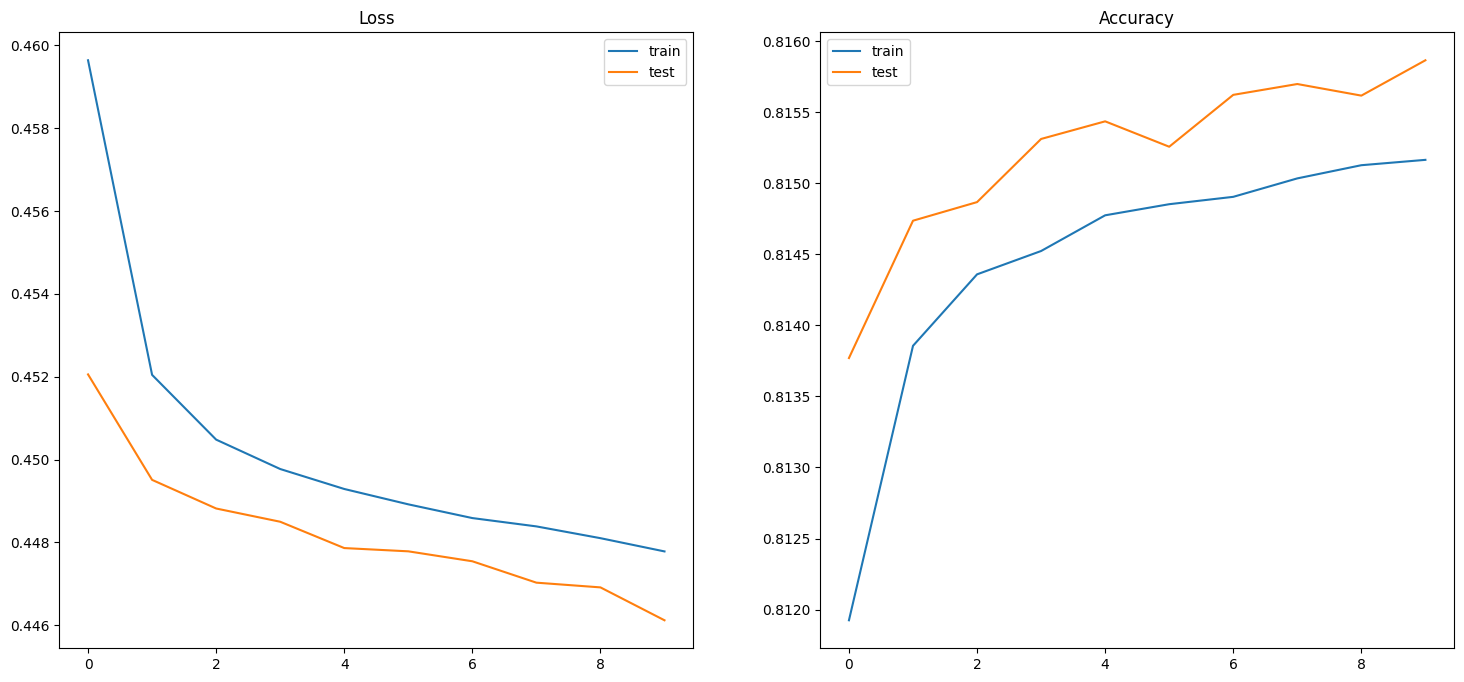

In [6]:
# # Neural Network model
nn_df = df.copy()
X_train_NN, X_test_NN, y_train_NN, y_test_NN = preprocessing.prepare_data_for_ML_model(nn_df, True)

nn_model = create_model.define_NN_model(X_train_NN)
history = create_model.train_NN_model(nn_model, X_train_NN, X_test_NN, y_train_NN, y_test_NN)
create_model.show_NN_performance(history)